<a href="https://colab.research.google.com/github/sanjay-raghu/test_site/blob/master/Unsupervised_clustering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
from google.colab import drive
drive.mount('/content/drive/')

#moving in pecan folder
import os
os.chdir('/content/drive/My Drive/client')
os.listdir()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['gostops']

In [0]:
# # firebase setup
# !pip install python-firebase

In [0]:
# #firebase test
# from firebase import firebase
# db_url = 'https://data-tagging-6d24a.firebaseio.com/'
# table = 'events' 
 
# firebase = firebase.FirebaseApplication(db_url, None)
# data =  { 'time': datetime.datetime.now(),
#           'events_type': 'noise',
#           'transition_duration' : 5,
#          'another_thing': 'something'
#           }
# result = firebase.post(f'/python-example-f6d0b/{table}/',data)
# print(result)

In [238]:
# tunydb installtion
!pip install tinydb


In [0]:
import pandas as pd
import numpy as np
import datetime
import glob
from dateutil.parser import parser
import os

In [0]:
import numpy as np
def ignore_close_events(events, delta = '1s'):
  new_arr = []
  for e1, e2 in zip(events[-1::-1],events[-2::-1]):
    # print(e2, e1)
    if abs(pd.Timestamp(e2) - pd.Timestamp(e1)) > pd.Timedelta(delta):
      new_arr.append(e1)
  new_arr.append(events[0])
  print('previous total events:', len(events))
  print('new total events:', len(new_arr))
  print(f'{(len(events) - len(new_arr))*100/len(events)} percent events ignored')
  return np.array(new_arr)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from datetime import datetime, timedelta
def get_features():
  pass

def look_around(df, event, before = '1m', after ='1m'):
  return df[(df.index > pd.Timestamp(event,tz = 'UTC')-pd.Timedelta(before)) & (df.index < pd.Timestamp(event,tz = 'UTC') + pd.Timedelta(after))]

def plot_df(df, event):
    ax = df.plot(figsize = (12, 8))
    ax.axvline(x=pd.Timestamp(event), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) + pd.Timedelta('1s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) - pd.Timedelta('1s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) + pd.Timedelta('5s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) - pd.Timedelta('5s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) + pd.Timedelta('10s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})
    ax.axvline(x=pd.Timestamp(event) - pd.Timedelta('10s'), **{'ls' : '--', 'lw' : .4, 'c' : 'r'})

def add_new_state_change(app, db ):
    docs = db.all()
    # print(docs)
    l = len(docs)
    print('new_id', l)
    app['ids'] = l
    db.insert(app)
    docs = db.all()
    print(docs)
    l = len(docs)
    print(l)
def get_appliance_list(db):
    try:
        doc = db.all()[0]
    except Exception as e:
        doc = []
    return doc['list']
    


def get_new_event(time = "", event_type = "", app_name = "", before_state = "", after_state="", transient_duration = None, signature = {}, multi_event = False, multi_event_location = []):
    event = {
        'time': time,
        'event_type' : event_type,
        'appliance_name': app_name,
        'before_state': before_state,
        'after_state':after_state,
        'transient_duration': transient_duration,
        'signature':signature,
        'multi_event' : multi_event,
        'multi_event_location': multi_event_location
    }
    print(event)
    return event
def get_new_state_change(app_name = "", event_type = "", before_state = "", after_state = "", signature = {}, deltap = ""):
    state_change = {
        'appliance_name': app_name,
        'event_type': event_type,
        'before_state': before_state,
        'after_state':after_state,
        'signature':signature,
        'deltap':deltap
    }
    print(state_change)
    return state_change
  
def prompt_known_events(db):
    docs = db.all()
    for doc in docs:
        print(doc)


def generate_grafana_link(time, meter_id = 'm190601057'):
    t1 = (int(time.strftime("%s")) - 3600) * 1000
    t2 = (int(time.strftime("%s")) + 3600) * 1000
    url = f"https://devdashboard.avrio.energy/d/kjnasdus/anymeter?orgId=1&var-Meter_ID={meter_id}&from={t1}&to={t2}"
    print(url)
from IPython.display import display
def plot_known_appliances(db):
    docs = db.all()
    n = len(docs)
    if n == 0:
        print('empty database')
    else:
        df = pd.DataFrame(docs)
        display(df.drop(columns=['signature']))

def analyse_chunk(data, filtered_events, events_db, appliance_db):
    for index, row in filtered_events.iterrows():
        event = index
        
        print(f'{str(event)}')
        print(f'event_name {row["event_name"]}')
        
        q = Query()
        r = events_db.search(q.time == str(event))
        # print(r)
        # break
        if r:
            print('event already tagged')
            continue
        generate_grafana_link(event)
        df = look_around(data[['mains:active_power', 'mains:reactive_power']], event, before = '30s', after = '30s')
        plot_df(df/100, event)
        plt.show()
        signature = df.reset_index()
        signature['index'] = signature['index'].astype(str) 
        signature = signature.set_index('index',)
        # print(signature)
        # print(signature.to_dict())
        event_type = input('event type ? (noise/n, up/u, down/d)')
        if event_type == 'noise' or event_type == 'n':
            d = get_new_event(time = str(event), event_type = "noise", transient_duration = None, signature = signature.to_dict(), multi_event = False, multi_event_location = [])
            print(f"adding to noise events")
            events_db.insert(d)

        elif event_type == 'up' or event_type == 'u':
            plot_known_appliances(appliance_db)
            new_event = input(f'new event ?(y/n)')
            if new_event == 'y':
                app_name = input('name of the appliance?')
                before_state = input('before state?')
                after_state = input('after state?')
                transient_duration = input('transient duration?')
                multi_event = int(input('how many extra events in transient duration(integer)?'))
                multi_event_location = []
                deltap = input('delta Powers (P, Q)?')
                for i in range(multi_event):
                    location = input(f"locations extras event number {i}?")
                    multi_event_location.append(location)
                add_new_state_change(s, appliance_db)
            elif new_event == 'n':
                select_id = input('select id from known appliance')
                select_id = int(select_id)
                q = Query()
                query_res = appliance_db.search(q.ids == select_id)[0]

                app_name = query_res['appliance_name']
                before_state = query_res['before_state']
                after_state = query_res['after_state']
                transient_duration = input('transient duration?')
                multi_event = int(input('how many extra events in transient duration(integer)?'))
                multi_event_location = []

            
            d = get_new_event(time = str(event), event_type = "up", app_name = app_name, before_state=before_state, after_state=after_state,
                        transient_duration = transient_duration, signature = signature.to_dict(), multi_event = multi_event,
                        multi_event_location = multi_event_location)
            s = get_new_state_change(app_name = app_name, event_type = "up", before_state = before_state,
                                after_state = after_state, signature = signature.to_dict(), deltap = deltap)
            events_db.insert(d)
            # appliance_db.insert(s)
        elif event_type == 'down' or event_type == 'd':
            plot_known_appliances(appliance_db)
            new_event = input(f'new event ?(y/n)')
            if new_event == 'y':
                app_name = input('name of the appliance?')
                before_state = input('before state?')
                after_state = input('after state?')
                transient_duration = input('transient duration?')
                multi_event = int(input('how many extra events in transient duration(integer)?'))
                multi_event_location = []
                deltap = input('delta Powers (P, Q)?')
                for i in range(multi_event):
                    location = input(f"locations extras event number {i}?")
                    multi_event_location.append(location)
                add_new_state_change(s, appliance_db)
            elif new_event == 'n':
                select_id = input('select id from known appliance')
                select_id = int(select_id)
                q = Query()
                query_res = appliance_db.search(q.ids == select_id)[0]

                app_name = query_res['appliance_name']
                before_state = query_res['before_state']
                after_state = query_res['after_state']
                transient_duration = input('transient duration?')
                multi_event = int(input('how many extra events in transient duration(integer)?'))
                multi_event_location = []
            
            d = get_new_event(time = str(event), event_type = "down", app_name = app_name, before_state=before_state, after_state=after_state,
                        transient_duration = transient_duration, signature = signature.to_dict(), multi_event = multi_event,
                        multi_event_location = multi_event_location)
            s = get_new_state_change(app_name = app_name, event_type = "down", before_state = before_state,
                                after_state = after_state, signature = signature.to_dict(), deltap = deltap)
            events_db.insert(d)
        clear_output(wait = True)
        ops = input('what to do next?(next-1,)')
        if ops == 'next' or ops == '1':
            continue
        else:
            break

In [0]:
def preprocess(data, t1_act = 5000):
    # sign of data
    pos = (data['mains:active_power'] > 0).sum()/ data.shape[0]
    if pos >= .5:
        sign = 1
    else:
        sign = -1
    data = data*sign

    # Featues Extractioon
    data['act_diff2'] = data['mains:active_power'].diff(2).shift(-1)
    data['act_diff4'] = data['mains:active_power'].diff(4).shift(-2)
    data['act_diff6'] = data['mains:active_power'].diff(6).shift(-3)
    data['act_diff8'] = data['mains:active_power'].diff(8).shift(-4)

    # data['react_diff2'] = data['mains:reactive_power'].diff(2).shift(-1)
    # data['react_diff4'] = data['mains:reactive_power'].diff(4).shift(-2)
    # data['react_diff6'] = data['mains:reactive_power'].diff(6).shift(-3)
    # data['react_diff8'] = data['mains:reactive_power'].diff(8).shift(-3)

    act_condition1 = (data['act_diff2'] > t1_act).apply(int) + (data['act_diff4'] > t1_act).apply(int) + (data['act_diff6'] > t1_act).apply(int) + (data['act_diff8'].apply(abs) > t1_act).apply(int)
    act_condition1 = act_condition1 >= 3  

    act_condition2 = (data['act_diff2'] < -t1_act).apply(int) + (data['act_diff4'] < -t1_act).apply(int) + (data['act_diff6'] < -t1_act).apply(int) + (data['act_diff8'].apply(abs) < -t1_act).apply(int)
    act_condition2 = act_condition2 >= 3

    # react_condition1 = (data['react_diff2'] > t1_react).apply(int) + (data['react_diff4'] > t1_react).apply(int) + (data['react_diff6'] > t1_react).apply(int) + (data['react_diff8'].apply(abs) > t1_react).apply(int)
    # react_condition1 = react_condition1 >= 3  

    # react_condition2 = (data['react_diff2'] < -t1_react).apply(int) + (data['react_diff4'] < -t1_react).apply(int) + (data['react_diff6'] < -t1_react).apply(int) + (data['react_diff8'].apply(abs) < -t1_react).apply(int)
    # react_condition2 = react_condition2 >= 3

    # con1 = ((data['act_diff2'].apply(abs) > t1_act) | (data['react_diff2'].apply(abs) > t1_react))
    # con2 = ((data['act_diff4'].apply(abs) > t1_act) | (data['react_diff4'].apply(abs) > t1_react))
    # con3 = ((data['act_diff6'].apply(abs) > t1_act) | (data['react_diff6'].apply(abs) > t1_react))
    # con4 = ((data['act_diff8'].apply(abs) > t1_act) | (data['react_diff8'].apply(abs) > t1_react))

    # event_filter1 = (con4 & con2 & con3)
    # event_filter2 = (con1 & con4 & con3)
    # event_filter3 = (con1 & con2 & con4)
    # event_filter4 = (con1 & con2 & con3)
    on_filter = act_condition1
    off_filter = act_condition2

    # event_filter = event_filter1 | event_filter2 | event_filter3 | event_filter4
    ##### on off events

    data['events'] = 0
    data['events'][on_filter] = 1
    data['events'][off_filter] = -1
    on_events = data.index[(data['events'] == 1)].values
    off_events = data.index[(data['events'] == -1)].values

    print(f"total {len(on_events)} on events detected and {len(off_events)} off events detected")

    filtered_on = ignore_close_events(on_events)
    filtered_off = ignore_close_events(off_events)
    print(f"total {len(filtered_on)} on events detected and {len(filtered_off)} off events detected")

    filtered_events = pd.DataFrame(index = pd.DatetimeIndex(np.concatenate([filtered_on, filtered_off])))
    filtered_events.loc[pd.DatetimeIndex(filtered_on), 'event_name'] = 'up'
    filtered_events.loc[pd.DatetimeIndex(filtered_off), 'event_name'] = 'down'
    filtered_events = filtered_events.sort_index()
    return filtered_events, data

In [253]:
home = '/content/drive/My Drive'
base = 'client'
client_name = 'gostops'
circuit_name = 'room_205'
tdelta = '200L'

cir_dir = os.path.join(home, base,client_name, circuit_name)
processed_dir = os.path.join(home, base,client_name, circuit_name, 'processed')
print(cir_dir)
print(processed_dir)

/content/drive/My Drive/client/gostops/room_205
/content/drive/My Drive/client/gostops/room_205/processed


In [0]:
# parameteres
t1_act = 5000
# t1_react= 2000

In [0]:
# db inint
from tinydb import TinyDB, Query
db_path = os.path.join(processed_dir, 'db.json')
db = TinyDB(db_path)
events_db = db.table('events_db')
appliance_db = db.table('appliances')



In [0]:
data_reader = pd.read_csv(os.path.join(processed_dir,'data' + tdelta +'.csv'), index_col=0, parse_dates=True, usecols = [0,1,2], chunksize = 3600*5*6 )

In [249]:
data = data_reader.__next__()
data.head()

,mains:active_power,mains:reactive_power
2019-11-23 02:44:38.400000+00:00,-8367.0,-1325.0
2019-11-23 02:44:38.600000+00:00,-7812.0,-1546.0
2019-11-23 02:44:38.800000+00:00,-8296.0,-1443.0
2019-11-23 02:44:39+00:00,-8363.0,-1325.0
2019-11-23 02:44:39.200000+00:00,-7804.0,-1551.0


In [254]:
filtered_events, df = preprocess(data,t1_act)

total 51 on events detected and 24 off events detected
previous total events: 51
new total events: 14
72.54901960784314 percent events ignored
previous total events: 24
new total events: 10
58.333333333333336 percent events ignored
total 14 on events detected and 10 off events detected


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


what to do next?(next-1,)1
2019-11-23 06:39:28.400000
event_name up
event already tagged
2019-11-23 06:39:34.800000
event_name down
event already tagged
2019-11-23 06:39:35.600000
event_name up
event already tagged
2019-11-23 06:40:16.600000
event_name down
event already tagged
2019-11-23 06:42:57
event_name up
https://devdashboard.avrio.energy/d/kjnasdus/anymeter?orgId=1&var-Meter_ID=m190601057&from=1574487777000&to=1574494977000


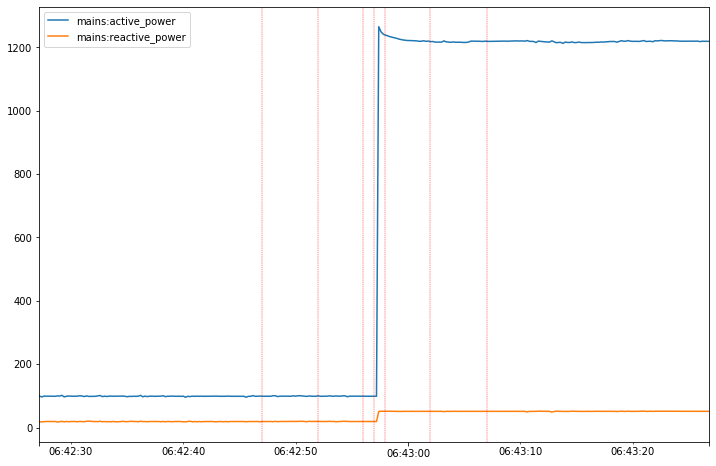

KeyboardInterrupt: ignored

In [255]:
analyse_chunk(df,filtered_events,events_db,appliance_db)

total 25 on events detected and 14 off events detected


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


previous total events: 25
new total events: 8
68.0 percent events ignored
previous total events: 14
new total events: 7
50.0 percent events ignored
total 8 on events detected and 7 off events detected


In [224]:
# display(filtered_events.head())

,event_name
2019-11-23 06:39:28.400,rising
2019-11-23 06:39:34.800,falling
2019-11-23 06:39:35.600,rising
2019-11-23 06:40:16.600,falling
2019-11-23 06:42:57.000,rising
2019-11-23 06:43:31.000,falling
2019-11-23 06:49:44.200,rising
2019-11-23 06:50:03.800,falling
2019-11-23 06:50:04.800,rising
2019-11-23 06:50:19.200,falling


In [0]:
events_db.purge()
appliance_db.purge()

In [0]:
# db init
# events_db.all()

what to do next?(next-1,)1
2019-11-23 06:42:57
event_name rising
https://devdashboard.avrio.energy/d/kjnasdus/anymeter?orgId=1&var-Meter_ID=m190601057&from=1574487777000&to=1574494977000


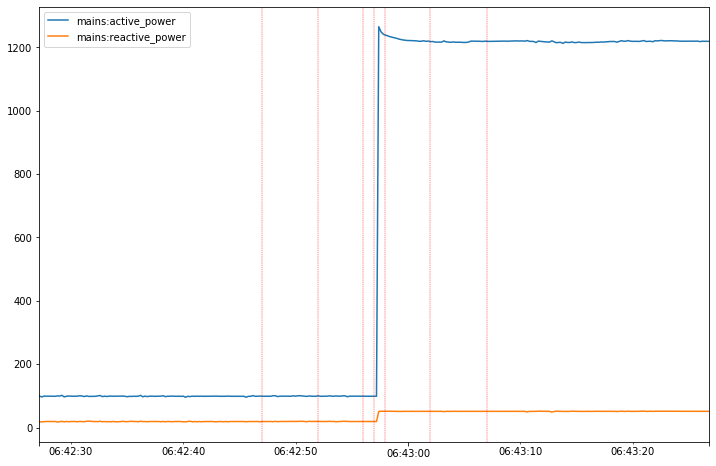

KeyboardInterrupt: ignored